In [2]:
import os
import json
import pandas as pd
from tqdm import tqdm

In [3]:
import os
import jsonlines
from tqdm import tqdm

save_names = ['llava_pretrain']
data = {name: [] for name in save_names}
file_path = '/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/jsons/alignment_2.5m.jsonl'
base_path = '/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment'

# Count the total number of lines for the progress bar
total_lines = sum(1 for _ in open(file_path))

with jsonlines.open(file_path) as reader:
    for entry in tqdm(reader, total=total_lines, desc="Processing entries"):
        data_split = entry['image'].split('/')[1]
        
        if data_split in save_names:
            if data_split == 'llava_pretrain':
                entry['image'] = entry['image'].replace('llava_pretrain/images', 'sbu558k')
            image_path = os.path.join(base_path, entry['image'])
            image_path = os.path.normpath(image_path)
            
            if os.path.exists(image_path):
                data[data_split].append(entry)
            else:
                break
# count the number of each dataset
for key, entries in data.items():
    print(f"{key}: {len(entries)}")


Processing entries: 100%|██████████| 2513677/2513677 [01:45<00:00, 23924.72it/s] 

llava_pretrain: 558128


/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/sbu558k/00120/001200924.jpg

In [4]:
# save as json for each data
for key, entries in data.items():
    save_path = f'/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/jsons/{key}.json'
    with open(save_path, 'w') as f:
        json.dump(entries, f)
    print(f"Saved {len(entries)} entries to {save_path}")

Saved 558128 entries to /home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/jsons/llava_pretrain.json


In [5]:
import torch
from tqdm import tqdm
def get_linear_input(sequence_output):
    cls_token = sequence_output[:, 0]
    patch_tokens = sequence_output[:, 1:]
    linear_input = torch.cat([cls_token, patch_tokens.mean(dim=1)], dim=1)
    return linear_input
directory = '/home/mila/l/le.zhang/scratch/light_align/data/image_embedding/dinov2-base'
for filename in os.listdir(directory):
    if filename.endswith(".pt"):
        print(os.path.join(directory, filename))
        image_embedding = torch.load(os.path.join(directory, filename))
        image_embedding = get_linear_input(image_embedding)
        torch.save(image_embedding, os.path.join(directory, filename))
    else:
        continue

In [49]:
import torch
import random

def compare_random_tensor_value(pt_file1, pt_file2, position=None):
    # 加载 .pt 文件
    tensor1 = torch.load(pt_file1,weights_only=True)
    tensor2 = torch.load(pt_file2,weights_only=True)
    # 如果没有指定位置，随机选择一个索引位置
    if position is None:
        position = random.randint(0, len(tensor1) - 1) 
    # 获取指定位置的值
    value1 = tensor1[position]
    value2 = tensor2[position]
    
    # 比较两个值并打印结果
 
    print(f"The values at position {position} of index {index} are different.\n"
              f"File 1 value: {value1}\nFile 2 value: {value2}")
    
    # return value1, value2

index = random.randint(150,200)
pt_file1 = f"/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/text_embedding/gte-large-en-v1.5/dreamclipcc3m_raw_caption/{index}.pt"
pt_file2 = f"/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/text_embedding/gte-large-en-v1.5/dreamclipcc3m_raw/{index}.pt"
compare_random_tensor_value(pt_file1,pt_file2)

The values at position 453 of index 198 are different.
File 1 value: tensor([-0.3914,  0.3975,  0.4602,  ...,  0.1035, -0.6128, -0.0597],
       dtype=torch.float16)
File 2 value: tensor([-0.3909,  0.3979,  0.4596,  ...,  0.1028, -0.6126, -0.0595])


In [ ]:
random.randint(120)

In [ ]:
import glob
import os
from natsort import natsorted
path_list = ['/home/mila/l/le.zhang/scratch/light_align/data/image_embedding/dinov2-large/ALLaVAVFLAN', '/home/mila/l/le.zhang/scratch/light_align/data/image_embedding/dinov2-large/LLaVA558K']
all_files = []
for dir_path in path_list:
    files = glob.glob(os.path.join(dir_path, "*.pt"))
    sorted_files = natsorted(files)
    all_files.extend(sorted_files)
all_files

In [ ]:
import os
import json
# read json
with open('/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/jsons/llava_pretrain.json', 'r') as f:
    sharegpt4v = json.load(f)
with open('/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/jsons/sbu558k.json', 'r') as f:
    sbu558k = json.load(f)
with open('/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/jsons/coco.json', 'r') as f:
    coco = json.load(f)




In [ ]:
# function to caculate avg length 
def avg_length(data):
    avg = 0
    for entry in data:
        avg += len(entry['conversations'][-1]['value'])
    return avg/len(data)

avg_length(sharegpt4v), avg_length(sbu558k), avg_length(coco)

In [ ]:
sharegpt4v[0]

In [ ]:
import os
import torch
from natsort import natsorted
import glob

def merge_pt_files(directory):
    # 获取所有的 .pt 文件路径，并按名字顺序排序
    files = glob.glob(os.path.join(directory, "*.pt"))
    files = natsorted(files)
    
    # 确保文件数量为偶数
    if len(files) % 2 != 0:
        raise ValueError("The number of .pt files is not even. Please make sure the files can be paired.")

    # 遍历所有文件，按两个为一组进行合并
    for i in range(0, len(files), 2):
        file1 = files[i]
        file2 = files[i+1]
        
        # 加载两个文件
        tensor1 = torch.load(file1)
        tensor2 = torch.load(file2)
        
        # 在第一个维度进行拼接
        merged_tensor = torch.cat((tensor1, tensor2), dim=0)
        
        # 生成新文件名
        base_name1 = os.path.basename(file1).replace(".pt", "")
        base_name2 = os.path.basename(file2).replace(".pt", "")
        new_file_name = f"{base_name1}_{base_name2}.pt"
        new_file_path = os.path.join(directory, new_file_name)
        
        # 保存拼接后的tensor
        torch.save(merged_tensor, new_file_path)
        print(f"Saved merged tensor to {new_file_path}")

# 示例用法
# merge_pt_files('/path/to/your/directory')


In [ ]:
import os
import glob
import torch
from tqdm import tqdm
file_dir = "/home/mila/l/le.zhang/scratch/light_align/data/text_embedding/gte-large-en-v1.5/dreamclipcc12mhf_longSV_captions"
files = glob.glob(os.path.join(file_dir, "*.pt"))
total_len = 0
for file in tqdm(files):
    tensor = torch.load(file, map_location=torch.device('cpu'), weights_only=False)
    total_len += tensor.size(0)
    if tensor.size(0) != 1024:
        print(file, tensor.size(0))
print(total_len)



 89%|████████▉ | 6678/7519 [01:25<00:11, 75.70it/s] 

/home/mila/l/le.zhang/scratch/light_align/data/text_embedding/gte-large-en-v1.5/dreamclipcc12mhf_longSV_captions/7518.pt 901


100%|██████████| 7519/7519 [01:35<00:00, 79.02it/s] 

7699333


In [ ]:
import torch
vision_embedding = torch.load('/home/mila/l/le.zhang/scratch/light_align/data/text_embedding/gte-large-en-v1.5/dreamclipcc12m_longSV_captions/5859.pt')
print(vision_embedding.shape)   
vision_embedding[54]

In [6]:
import os
import glob
import torch
from tqdm import tqdm
file_dir = "/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-base/dreamclipcc12mhf"
files = glob.glob(os.path.join(file_dir, "*.pt"))
total_len = 0
for file in tqdm(files):
    tensor = torch.load(file, map_location=torch.device('cpu'), weights_only=False)
    total_len += tensor.size(0)
    if tensor.size(0) != 1024:
        print(file, tensor.size(0))
print(total_len)



 90%|████████▉ | 6738/7519 [00:46<00:05, 150.44it/s]

/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-base/dreamclipcc12mhf/7518.pt 901


100%|██████████| 7519/7519 [00:52<00:00, 143.44it/s]

7699333


In [1]:
import os
import glob
import torch
from tqdm import tqdm
file_dir = "/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-giant/dreamclipcc3m"
files = glob.glob(os.path.join(file_dir, "*.pt"))
total_len = 0
for file in tqdm(files):
    tensor = torch.load(file, map_location=torch.device('cpu'), weights_only=False)
    total_len += tensor.size(0)
    if tensor.size(0) != 1024:
        print(file, tensor.size(0))
print(total_len)



100%|██████████| 2186/2186 [01:45<00:00, 20.78it/s]

/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-giant/dreamclipcc3m/2185.pt 633
2238073


In [ ]:
import pandas as pd
from data_config import DATADIR
# load csv file
csv = pd.read_csv(DATADIR['dreamclipcc12mhf']['annotation'], nrows=100000)
csv

,Image Url,raw_caption,shortIB_captions,longIB_captions,shortSV_captions,longSV_captions,shortLLA_captions,longLLA_captions,Image Path
0,http://1.bp.blogspot.com/_dWmIOlGB7_0/S_HA9F1R...,this watch rolex gmt master has an independent...,a rolex watch with red and black dials,The image showcases a stunning silver and red ...,A Rolex watch with a black face and red and wh...,The image showcases a Rolex Submariner wristwa...,A silver and black watch with a red second hand.,The image features a silver and black wristwat...,CC12M_HF/images/0000000/0000000.jpg
1,http://2.bp.blogspot.com/-TwtZYTU4e9I/UQmEywkl...,picture of white modern bathroom furniture as ...,a white toilet sitting next to a sink in a bat...,The image showcases a modern and stylish bathr...,"A bathroom with a white toilet, sink, and mirror.","The image captures a modern bathroom, bathed i...",A bathroom with a toilet and sink.,The image depicts a modern bathroom with a whi...,CC12M_HF/images/0000000/0000002.jpg
2,http://2.bp.blogspot.com/--K8LdRsj99U/VQaOjr33...,the american cowboy chronicles native american...,a close up of a brown bear with its mouth open,The image features a large brown bear with its...,A close up of a bear with its mouth wide open.,The image captures a close-up view of a brown ...,A close up of a brown bear with its mouth open.,The image features a large brown bear with its...,CC12M_HF/images/0000000/0000003.jpg
3,http://2.bp.blogspot.com/-MBHbOy37tvU/TaX19Rrr...,assimilation process in the indian style and f...,a woman in a pink sari sitting on a bed,"In the picture, there are visible objects such...",A woman in a long pink dress sitting on a bed.,"In the image, a woman is the central figure, s...",A woman is sitting on a bed with a pink dress.,The image features a beautiful woman wearing a...,CC12M_HF/images/0000000/0000004.jpg
4,http://2.bp.blogspot.com/-2HQcTDQ4oQs/V1oBoudL...,in mourning afterglow album lyrics in mourning...,a painting of a lighthouse in the middle of a ...,The painting depicts a lighthouse standing on ...,A painting of a rocky island in the middle of ...,The image presents a dramatic scene of a rocky...,A painting of a lighthouse on a rocky island s...,The image depicts a dramatic scene of a lighth...,CC12M_HF/images/0000000/0000005.jpg
...,...,...,...,...,...,...,...,...,...
99995,https://ih1.redbubble.net/image.101238260.5977...,there is always hope classic t shirt,"a purple awareness ribbon with the words, i am...",The image showcases a purple awareness ribbon ...,A dark blue shirt with a teal ribbon on it.,The image showcases a navy blue t-shirt that i...,A blue shirt with a teal ribbon on it that say...,The image features a person wearing a blue shi...,CC12M_HF/images/0000012/0007289.jpg
99996,https://ih1.redbubble.net/image.1015926394.744...,this is for person graphic t shirt,a man wearing a white t shirt with black text ...,"In the image, the person is wearing a graphic ...",A young man wearing a white and black t-shirt ...,"In the image, a young man is the central figur...",A man wearing a black and white shirt with a m...,The image features a young man wearing a white...,CC12M_HF/images/0000012/0007290.jpg
99997,https://ih1.redbubble.net/image.1095232363.234...,the dog in the snow samsung galaxy snap case,a wolf in the snow samsung galaxy snap case,The image features a snow-covered mountain lan...,A dog in the snow looking at the mountains.,The image captures a serene winter scene. A br...,A dog is standing in the snow with mountains i...,The image features a snowy mountain landscape ...,CC12M_HF/images/0000012/0007291.jpg
99998,https://ih1.redbubble.net/image.1093540126.726...,person in the garden beatrix potter clock,a clock on the wall with an image of a cartoon...,"In the image, there are several objectively ex...",A round clock with a rabbit and a bird on it h...,The image presents a minimalist interior setti...,A clock with a picture of a boy and a girl on ...,The image features a white wall with a clock h.

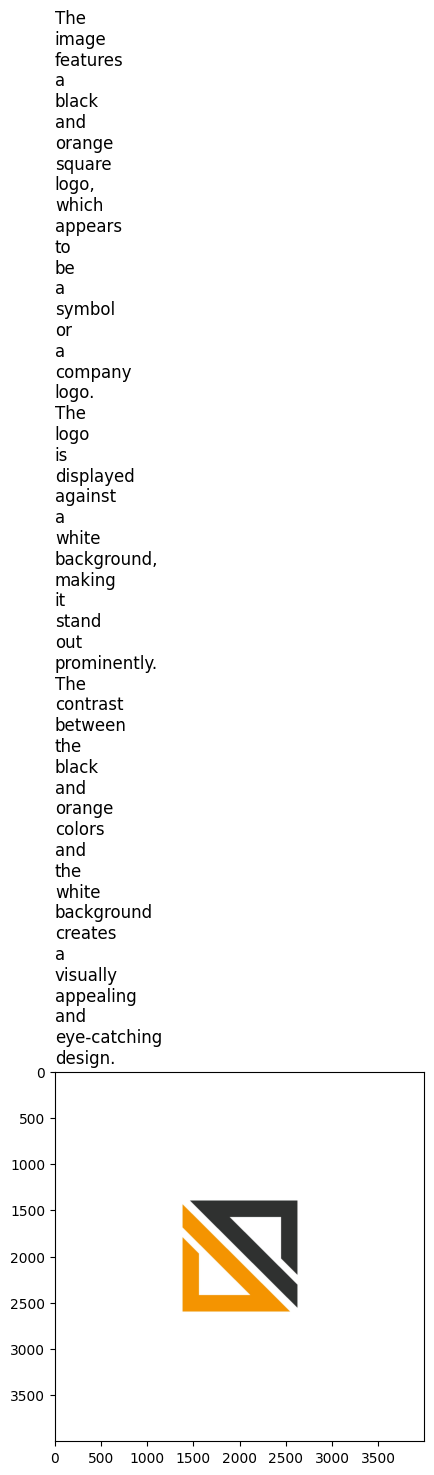

In [ ]:
# open image and show
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
# 指定index为5的行是我们要显示的图像
index = random.randint(0, 100000)
image_path = os.path.join(DATADIR['dreamclipcc12mhf']['imagedir'], csv.iloc[index]['Image Path'])

# 打开图像并显示 标题为caption
image = Image.open(image_path)
plt.imshow(image)
plt.title("\n".join(csv.iloc[index]['longLLA_captions'].split(" ")), loc='left')
plt.show()


In [3]:
import torch
tensor_a = torch.load('/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-large/ALLaVAVFLAN/1.pt', weights_only=True)

In [7]:
# measure memory usage of tensor_a in human readable format
print(f"{tensor_a.element_size() * tensor_a.nelement() / 1024 / 1024:.2f} MB")

16.00 MB


In [8]:
# transform to fp16 and see again
tensor_b = tensor_a.to(torch.float16)
print(f"{tensor_b.element_size() * tensor_b.nelement() / 1024 / 1024:.2f} MB")

8.00 MB
